### In this notebook I continued the effort of finding an improved afib model, given the coefficients...in this notebook I tried using a logistic risk factor model, and a logistic risk factor model, given the coefficients does not produce meaningful results.

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt
import importlib.util

In [13]:
from microsim.data_loader import load_model_spec, load_regression_model
from microsim.population import NHANESDirectSamplePopulation, initializeAFib
from microsim.sim_settings import simSettings
from microsim.statsmodel_logistic_risk_factor_model import StatsModelLogisticRiskFactorModel
from microsim.cohort_risk_model_repository import CohortRiskModelRepository
from microsim.stats_model_linear_probability_risk_factor_model import (StatsModelLinearProbabilityRiskFactorModel)
from microsim.statsmodel_linear_risk_factor_model import StatsModelLinearRiskFactorModel
from microsim.statsmodel_logistic_risk_factor_model import StatsModelLogisticRiskFactorModel

In [3]:
pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel

seedSequence = np.random.SeedSequence()
rngStream = np.random.default_rng(seed=seedSequence)

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

In [16]:
gbdData=pd.read_csv("/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA/IHME-GBD_2019_DATA-afib/IHME-GBD_2019_DATA-8086e0fc-1.csv")
#gbdData.head(3)

In [17]:
#the reference afib data will be based on the 2019 US GBD data
afibRef = gbdData.loc[ 
    (gbdData["metric_name"]=="Percent") & (gbdData["age_id"].isin([16,17,18,19,20,30,31,32,235]))
    ,["val"]]["val"].tolist()
#afibRef

In [8]:
popSize = 500000
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)

100000
200000
300000
400000
500000


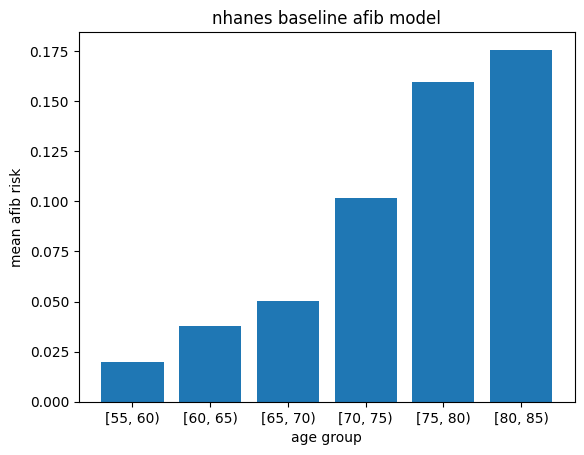

In [9]:
#do the bin counting for the baseline model
ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age
    afibList += p._afib 
    pDone = len(ageList)
    if pDone%100000==0:
        print(pDone)
        
baseAfib = pd.DataFrame(list(zip(ageList,afibList)), columns=["age","afib"])
baseAfib["age"]=baseAfib["age"].astype('int')
baseAfib["ageInterval"] = pd.cut(baseAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)

baseAfibMeansByAgeGroup = baseAfib.groupby("ageInterval").agg({'afib' : 'mean'})
baseAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  baseAfibMeansByAgeGroup.index.array]

labels = baseAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in baseAfibMeansByAgeGroup.values[1:]]
#reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes baseline afib model")
plt.show()

In [12]:
#we will do this now for the cohort afib model
#the difference is that now we need to advance the population and use the data from all person-years
module = importlib.import_module("microsim.cohort_risk_model_repository")

intercept = load_regression_model("afibCohortModel")._coefficients["Intercept"]
interceptStep = 0.25
interceptChange = 0

In [14]:
#try perhaps a custom model

class StatsAfibModel(StatsModelLogisticRiskFactorModel):
    def __init__(self, regression_model):
        super().__init__(regression_model, False)

    def estimate_next_risk(self, person, rng=None):
        #rng = np.random.default_rng(rng)
        linearRisk = super().estimate_next_risk(
            person
        )
        #riskWithResidual = linearRisk + self.draw_from_residual_distribution(rng)
        #return rng.uniform() < riskWithResidual 
        return rng.uniform() < linearRisk

    def estimate_next_risk_vectorized(self, x, rng=None):
        #rng = np.random.default_rng(rng)
        linearRisk = super().estimate_next_risk_vectorized(x)
        #riskWithResidual = linearRisk + self.draw_from_residual_distribution(rng)
        #return rng.uniform()  < riskWithResidual 
        return rng.uniform() < linearRisk

In [15]:
def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept):
    model = load_regression_model(modelName)
    if (referenceName=="afib"):
        model._coefficients["Intercept"] = intercept
        self._repository[referenceName] = StatsAfibModel(model)   #try the custom model
        #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model) #or the default model
        #print("intercept = ", intercept)
    else:
        self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
    #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)

CohortRiskModelRepository._initialize_linear_probability_risk_model = _initialize_linear_probability_risk_model
setattr(module, "CohortRiskModelRepository", CohortRiskModelRepository)
from microsim.cohort_risk_model_repository import CohortRiskModelRepository

In [22]:
popSize = 1000

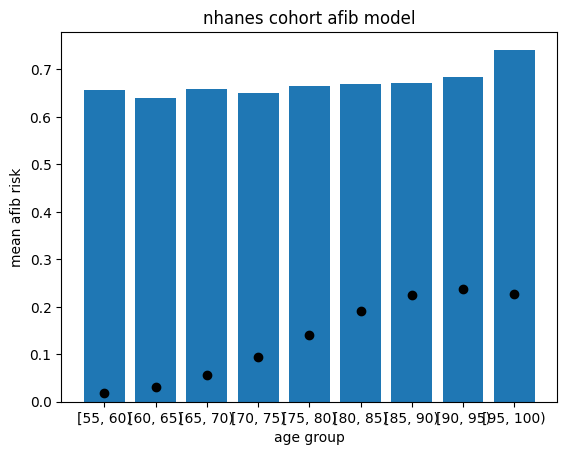

In [23]:
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
alive, dead = pop.advance_vectorized(150,rng=rngStream)

ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age[1:]
    afibList += p._afib[1:-1] 
    #pDone = len(ageList)
    #if pDone%100000==0:
     #   print(pDone)
        
cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
cohortAfib["afib"]=cohortAfib["afib"].astype('int')
cohortAfib["age"]=cohortAfib["age"].astype('int')

cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

labels = cohortAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in cohortAfibMeansByAgeGroup.values[1:]]
reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
for i in range(len(reference)):
    ax.scatter(labels[i],reference[i],color="black")
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes cohort afib model")
plt.show()

In [24]:
#find how far off we are from the GBD prevalence
afibSim = cohortAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
#afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)]
#afibDiffWeighted = [y/x for x,y in zip(afibRef,afibDiff)]
afibDiffWeighted = [1*y for x,y in zip(afibRef,afibDiff)]
afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
afibDiffWeightedSum = sum( afibDiffWeighted)

#define the change in the model intercept based on the difference
if (afibDiffWeightedSum>0.):
    interceptChange += interceptStep
else:
    interceptChange += -interceptStep

In [25]:
for run in range(0,10):

    #if (run%10==0):
    print(f"run= {run} intercept= {intercept} step= {interceptStep} change= {interceptChange}")
    intercept += interceptChange
    
    def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept):
        model = load_regression_model(modelName)
        if (referenceName=="afib"):
            model._coefficients["Intercept"] = intercept
            self._repository[referenceName] = StatsAfibModel(model) #use the custom model
            #print("intercept = ", intercept)
        else:
            self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model) #and the default model for all else
        #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model) #or just use the default for all

    CohortRiskModelRepository._initialize_linear_probability_risk_model = _initialize_linear_probability_risk_model
    setattr(module, "CohortRiskModelRepository", CohortRiskModelRepository)
    from microsim.cohort_risk_model_repository import CohortRiskModelRepository
    
    pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
    alive, dead = pop.advance_vectorized(150,rng=rngStream)

    ageList = list()
    afibList = list()
    for p in pop._people.iloc[:]:
        ageList +=  p._age[1:]
        afibList += p._afib[1:-1] 
        #pDone = len(ageList)
        #if pDone%100000==0:
         #   print(pDone)
        
    cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
    cohortAfib["afib"]=cohortAfib["afib"].astype('int')
    cohortAfib["age"]=cohortAfib["age"].astype('int')

    cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
    cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
    cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

    afibSim = cohortAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
    afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
    #afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)] #weight according to number of cases
    afibDiffWeighted = [1*y for x,y in zip(afibRef,afibDiff)] #or all equally
    #afibDiffWeighted = [y/x for x,y in zip(afibRef,afibDiff)]
    afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
    afibDiffWeightedSumOld = afibDiffWeightedSum
    afibDiffWeightedSum = sum( afibDiffWeighted)

    if (afibDiffWeightedSum*afibDiffWeightedSumOld<0) :
        interceptStep = interceptStep/2
    if (afibDiffWeightedSum>0.):
        interceptChange = interceptStep
    else:
        interceptChange = -interceptStep

run= 0 intercept= 0.006808684735369566 step= 0.25 change= -0.5
run= 1 intercept= -0.49319131526463045 step= 0.25 change= -0.25
run= 2 intercept= -0.7431913152646304 step= 0.25 change= -0.25
run= 3 intercept= -0.9931913152646304 step= 0.25 change= -0.25
run= 4 intercept= -1.2431913152646303 step= 0.25 change= -0.25
run= 5 intercept= -1.4931913152646303 step= 0.25 change= -0.25
run= 6 intercept= -1.7431913152646303 step= 0.25 change= -0.25
run= 7 intercept= -1.9931913152646303 step= 0.25 change= -0.25
run= 8 intercept= -2.2431913152646303 step= 0.125 change= 0.125
run= 9 intercept= -2.1181913152646303 step= 0.125 change= 0.125


In [41]:
#intercept += interceptChange
intercept = -2.118191315264630 + 0.125
intercept

-1.99319131526463

In [42]:
def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept):
        model = load_regression_model(modelName)
        if (referenceName=="afib"):
            model._coefficients["Intercept"] = intercept
            self._repository[referenceName] = StatsAfibModel(model)
            #print("intercept = ", intercept)
        else:
            self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
        #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)

CohortRiskModelRepository._initialize_linear_probability_risk_model = _initialize_linear_probability_risk_model
setattr(module, "CohortRiskModelRepository", CohortRiskModelRepository)
from microsim.cohort_risk_model_repository import CohortRiskModelRepository
    
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
alive, dead = pop.advance_vectorized(150,rng=rngStream)

ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age[1:]
    afibList += p._afib[1:-1] 
    #pDone = len(ageList)
    #if pDone%100000==0:
        #   print(pDone)
        
cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
cohortAfib["afib"]=cohortAfib["afib"].astype('int')
cohortAfib["age"]=cohortAfib["age"].astype('int')

cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

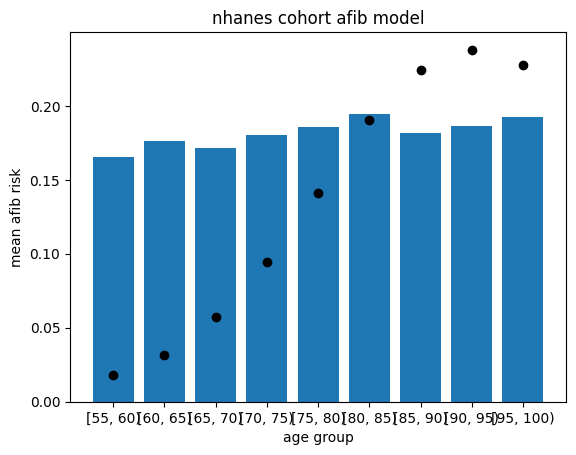

In [43]:
labels = cohortAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in cohortAfibMeansByAgeGroup.values[1:]]
reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
for i in range(len(reference)):
    ax.scatter(labels[i],reference[i],color="black")
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes cohort afib model")
plt.show()